# Face Generation using DCGAN


In this notebook a simple deep convolutioal gan is implemented


## Table Of Content

1. [Setup](#setup)
   1. [Set Parameter](#set-parameter)
   2. [Prepare Data](#prepare-data)
2. [Initialize GAN](#initialize-generator-and-discrimintor)
3. [Train GAN](#train-model)
4. [Evaluate](#evaluate)


## Imports


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm

from src.components import Discriminator, Generator

In [2]:
# to use gpu acceleration on mac uncomment the following line
device = torch.device(
    "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)
# to use gpu acceleration on windows uncomment the following line
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# set random seed for reproducibility
np.random.seed(42)

mps


## Setup


### Set Parameter


In [3]:
# model hyperparameters
learning_rate = 2e-4
batch_size = 128
img_size = 64
channels = 3
z_dim = 100
epochs = 10

# data parameters
data_path = "./data/"
val_set_size = 0.3

### Helper Functions


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels: int, features: int) -> None:
        """create a discriminator model

        Args:
            img_channels (int): number of input channels of the image (3 for RGB, 1 for grayscale)
            features (int): number of features in the first convolutional layer (multiplied by 2 in each subsequent layer, usually related to image size)
        """
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            self.conv_block(img_channels, features, kernel_size=4, stride=2, padding=1),
            self.conv_block(features, features * 2, kernel_size=4, stride=2, padding=1),
            self.conv_block(
                features * 2, features * 4, kernel_size=4, stride=2, padding=1
            ),
            self.conv_block(
                features * 4, features * 8, kernel_size=4, stride=2, padding=1
            ),
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

    def conv_block(
        self,
        in_channles: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ) -> nn.Sequential:
        """create a convolutional block with batch normalization and leaky relu activation

        Args:
            in_channles (int): number of input channels
            out_channels (int): number of output channels
            kernel_size (int, optional): kernel window size. Defaults to 4.
            stride (int, optional): size of striding window. Defaults to 2.
            padding (int, optional): size of padding window. Defaults to 1.

        Returns:
            nn.Sequential: a sequential block of convolutional layer, batch normalization and leaky relu activation
        """
        layer = [
            nn.Conv2d(
                in_channles,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(0.2),
        ]
        return nn.Sequential(*layer)

    def init_weights(self) -> None:
        """initialize weights of the model"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)


class Generator(nn.Module):
    def __init__(self, z_dim: int, img_channels: int, features: int) -> None:
        """create a generator model

        Args:
            z_dim (int): dimension of the input noise vector
            img_channels (int): number of output channels of the image (3 for RGB, 1 for grayscale)
            features (int): number of features in the first convolutional layer (multiplied by 2 in each subsequent layer, usually related to image size)
        """
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            self.trans_conv_block(
                z_dim, features * 16, kernel_size=4, stride=1, padding=0
            ),
            self.trans_conv_block(
                features * 16, features * 8, kernel_size=4, stride=2, padding=1
            ),
            self.trans_conv_block(
                features * 8, features * 4, kernel_size=4, stride=2, padding=1
            ),
            self.trans_conv_block(
                features * 4, features * 2, kernel_size=4, stride=2, padding=1
            ),
            nn.ConvTranspose2d(
                features * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        """function to forwad pass through the model"""
        return self.main(x)

    def trans_conv_block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ) -> nn.Sequential:
        """creating a transposed convolutional block consisting of convolutional layer, batch normalization, relu activation and dropout layer

        Args:
            in_channels (int): input channels
            out_channels (int): output channels
            kernel_size (int, optional): kernel window size. Defaults to 4.
            stride (int, optional): size of striding window. Defaults to 2.
            padding (int, optional): size of padding window. Defaults to 1.

        Returns:
            nn.Sequential: a sequential block of transposed convolutional layer, batch normalization, relu activation and dropout layer
        """
        layer = [
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout(0.25),
        ]
        return nn.Sequential(*layer)

    def init_weights(self) -> None:
        """initialize weights of the model"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

### Prepare Data


In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
# load images
data = ImageFolder(root=data_path, transform=transform)
idx = np.random.permutation(len(data))

# split data into train and validation
split = int(np.floor(val_set_size * len(data)))
train_idx, val_idx = idx[split:], idx[:split]

# create data loaders
train_sampler = SubsetRandomSampler(train_idx)
dl = DataLoader(data, batch_size=batch_size, sampler=train_sampler)

In [5]:
img = data[0]
img[0].shape

torch.Size([3, 64, 64])

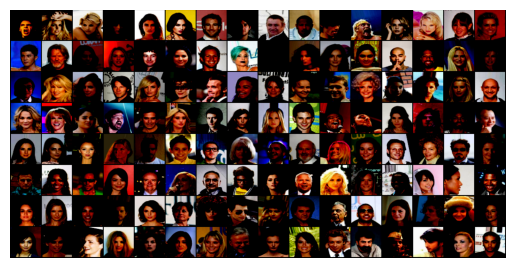

In [6]:
# select random batch of images to display
for images, _ in dl:
    images = images.reshape(images.size(0), channels, img_size, img_size)
    torchvision.utils.save_image(
        images, os.path.join(data_path, "real_images.png"), nrow=16
    )
    break

# display image
img = Image.open(os.path.join(data_path, "real_images.png"))
plt.imshow(img)
plt.axis("off")
plt.show()

## Initialize Generator and Discrimintor


In [7]:
gen = Generator(z_dim=z_dim, img_channels=channels, features=img_size).to(device)
gen.init_weights()

disc = Discriminator(img_channels=channels, features=img_size).to(device)
disc.init_weights()

In [8]:
g_optimizer = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss = nn.BCELoss()

## Train Model


In [9]:
losses_disc = list()
losses_gen = list()

for epoch in range(epochs):

    for image, _ in tqdm(dl, total=len(dl)):
        batch = image.size(0)
        image = image.to(device)

        # train discriminator
        # create fake image
        noise = torch.randn(batch, z_dim, 1, 1).to(device)
        fake_image = gen(noise)
        disc_real = disc(image).reshape(-1)
        disc_fake = disc(fake_image.detach()).reshape(-1)

        # calculate losses
        loss_disc_real = loss(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (loss_disc_real + loss_disc_fake) / 2

        # perform backpropagation and optimization
        disc.zero_grad()
        disc_loss.backward()
        d_optimizer.step()

        # train generator
        output = disc(fake_image).reshape(-1)
        g_loss = loss(output, torch.ones_like(output))

        gen.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # save losses to list
        losses_disc.append(disc_loss.item())
        losses_gen.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {disc_loss:.4f}, Loss G: {g_loss:.4f}")

100%|██████████| 1108/1108 [09:19<00:00,  1.98it/s]

Epoch [1/1] Loss D: 0.4748, Loss G: 3.2519


## Evaluate


### Plot Losses


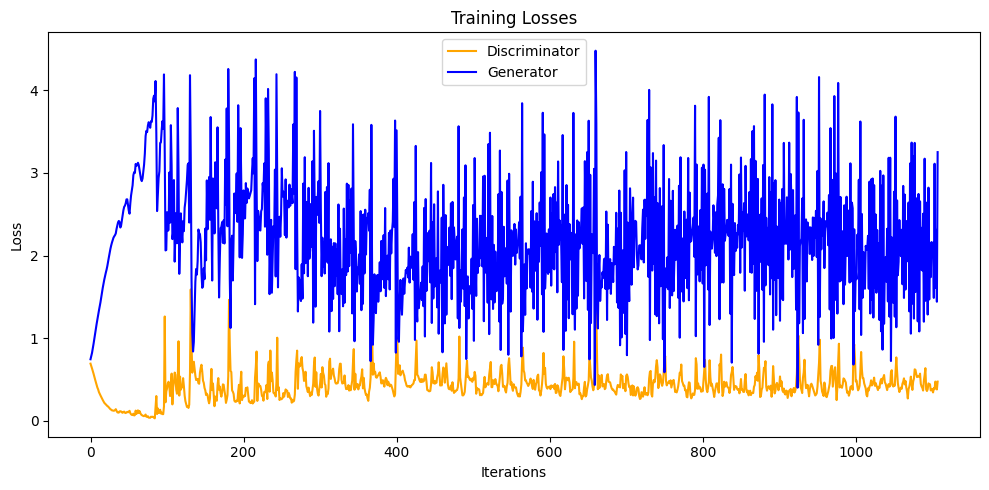

In [10]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(losses_disc, label="Discriminator", color="orange")
axes.plot(losses_gen, label="Generator", color="blue")

axes.set_xlabel("Iterations")
axes.set_ylabel("Loss")

axes.set_title("Training Losses")

axes.legend()

fig.tight_layout()

### Display Generated Images


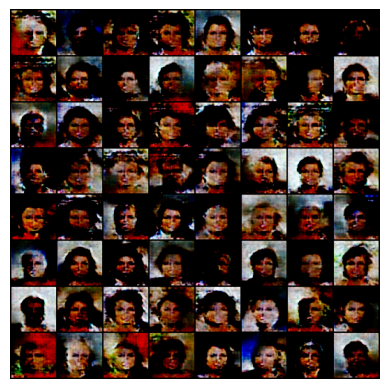

In [11]:
with torch.no_grad():
    noise = torch.randn(64, z_dim, 1, 1).to(device)
    fake_image = gen(noise)
    save_image(fake_image, os.path.join(data_path, "fake_image.png"), nrow=8)

# display image
img = Image.open(os.path.join(data_path, "fake_image.png"))
plt.imshow(img)
plt.axis("off")
plt.show()